## Proyecto 1

Empezamos importando nuestras librerías

In [145]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn import linear_model

Creamos la funcipón para la carga de datos. Aquí creamos nuestro dataframe, mezclamos su contenido y separamos nuestros datasets de entranamiento y y pruebas.

In [146]:
def cargaDatos():
    df = pd.DataFrame(np.load('proyecto_training_data.npy'), columns= ['SalePrice', 'OverallQual', '1stFlrSF', 'TotRmsAbvGrd', 'YearBuilt', 'LotFrontage'])
    df= df.sample(frac=1, ignore_index=True)
    filas = len(df)
    slicing = int(filas*0.8)
    df_entre = df[:slicing]
    df_prueba = df[slicing:]

    return df, df_entre, df_prueba

Creamos una clase para nuestros nuevos dataframes y los almacenamos en un objeto para seguir trabajando con la misma data durante todo el desarrollo del programa

In [147]:
class dataframes:
    def __init__(self, df, df_entre, df_prueba):
        self.df = df
        self.df_entre = df_entre
        self.df_prueba = df_prueba

df, df_entre, df_prueba = cargaDatos()

data = dataframes(df, df_entre, df_prueba)

Creamos la función para el análisis exploratorio de datos

In [5]:
def analisis():
    analisisExp = data.df_entre
    analisisExp = analisisExp.describe().loc[['mean','max', 'min', 'std'],:] # extraemos las columnas deseadas
    analisisExp = analisisExp.rename(index={'mean': 'Media','max':'Máximo', 'min':'Mínimo', 'std': 'Desviación estándar'})

    rango = pd.DataFrame({ #generamos los rangos restando los máximos y mínimos
            'SalePrice': [analisisExp['SalePrice'].max() - analisisExp['SalePrice'].min()],
            'OverallQual': [analisisExp['OverallQual'].max() - analisisExp['OverallQual'].min()],
            '1stFlrSF': [analisisExp['1stFlrSF'].max() - analisisExp['1stFlrSF'].min()],
            'TotRmsAbvGrd': [analisisExp['TotRmsAbvGrd'].max() - analisisExp['TotRmsAbvGrd'].min()],
            'YearBuilt': [analisisExp['YearBuilt'].max() - analisisExp['YearBuilt'].min()],
            'LotFrontage': [analisisExp['LotFrontage'].max() - analisisExp['LotFrontage'].min()]},
            index= ['Rango'])

    analisisExp = pd.concat([analisisExp, rango])
    analisisExp = analisisExp.loc[['Media','Máximo', 'Mínimo', 'Rango', 'Desviación estándar'],:] #cambiamos el orden de las columnas
    return analisisExp


Función para generar histogramas

In [6]:
def histogramas():
    for columna in data.df_entre.columns:
        sb.histplot(data.df_entre[columna], color='green').set(title=f'Histograma de {columna}', xlabel=columna, ylabel='Frecuencia')
        plt.show()

Función para calcular la correlación entre variables

In [189]:
def correlacion():
    corr = data.df_entre.corr() #correlacion
    mask = np.zeros_like(corr, dtype=bool) #mascara para ocultar los datos duplicados en el mapa de calor
    mask[np.triu_indices_from(mask)] = True
    f, ax = plt.subplots(figsize=(9, 7))
    sb.heatmap(corr, annot=True, cmap='Greens', mask=mask, vmax=0.8, vmin=0, square=True, linewidths=.8).set_title('Correlación entre columnas')
    plt.show()
    corr_pairs = corr.unstack().sort_values(ascending=False)
    corr_pairs = corr_pairs[corr_pairs != 1.0]
    corr_pairs = corr_pairs.iloc[[0,2]]
    corr1, corr2 = corr_pairs.index.tolist()
    print("Las dos correlaciones más altas son:")
    print(corr1, corr2)
    return corr_pairs

Función para graficar la disperción de las variables

In [8]:
def scatterplot():
    cols = data.df_entre.columns
    for i, a in enumerate(cols): #iteración de columna a
        for j, b in enumerate(cols): #iteración de columna b
            if i >= j: #condición para evitar gráficas duplicadas
                continue
            x = data.df_entre[a]
            y = data.df_entre[b]
            corr = round(x.corr(y), 2)
            title = f'Scatterplot de {a} vs {b} (Correlación: {corr})'

            plt.figure()
            plt.scatter(x, y, c='green', s=10,marker='.')
            plt.title(title)
            plt.xlabel(a)
            plt.ylabel(b)
            plt.show()

Elegimos nuestras variables independientes 'OverallQual' y '1stFlrSF' y como variable dependiente 'SalePrice', ya que son las que más correlación tienen con el precio de venta. Lo cuál es lógico porque el precio de venta puede cambiar por la calificación que le den a la casa y el metraje de la misma.

#### Función para el modelo de regresión linean

In [113]:
def regresion_lineal(x, y, epochs:int, imprimir_error_cada:int, rate:float):
    x = x.values
    y = y.values

    # Creamos la matriz x1 con una columna con el vector x otra llena de 1s
    x1 = np.hstack((x.reshape(-1, 1), np.ones_like(x.reshape(-1, 1))))
    
    # Inicializamos en 0 los parámetros donde betas = [b1, b0]
    betas = np.zeros((2,1))
    n = len(y)

    # Creamos una lista vacía para almacenar el error en cada iteración
    error = []

    # Creamos listas para almacenar yPrima y el número de iteración
    index = []
    yPrima = []
    
    for i in range(epochs):
        # Calculamos las predicciones del modelo para todos los datos
        y1 = np.dot(x1, betas)
        yPrima.append(y1)

        # Calculamos el error cuadrádito medio entre las predicciones y los valores reales
        costo = np.sum((y.reshape(-1,1) - y1) ** 2) / (2 * n)
        
        # Almacenamos el error en la lista
        error.append(costo)
        
        # Imprimimos el error con el número de iteración
        if (i+1) % imprimir_error_cada == 0:
            print(f"El error en el epoch {i+1} es de {costo}")
        
        # Obtenemos los gradientes donde gradiente = [gb1, gb0]
        gradientes = np.dot(x1.T, (y1 - y.reshape(-1, 1))) / n

        # Actualizamos b1 y b0
        betas = betas - np.dot(gradientes, rate)
        index.append(i)
        
    # Devolvemos los valores resultantes y error por cada iteración
    return index, error, yPrima

In [ ]:
index, error, yPrima = regresion_lineal(df_entre['OverallQual'], df_entre['SalePrice'], 10000, 1000, 0.01)

In [ ]:
index, error, yPrima = regresion_lineal(df_entre['1stFlrSF'], df_entre['SalePrice'], 50, 5, 0.0000001)

In [11]:
def graficaError(x,y):
    plt.plot(x, y, color='green')
    plt.title('Error por número de iteración')
    plt.xlabel('Iteración')
    plt.ylabel('Error')
    plt.show()

In [77]:
def graficarModelo(x,y,yPrima,n):
    x = x.values
    y = y.values
    for i in range(len(yPrima)):
        if (i+1) % n == 0:
            plt.figure()
            plt.scatter(x, y, c='green', s=10,marker='.')
            plt.plot(x, yPrima[i], c='red', linewidth= 2)
            plt.title(f'Regresión lineal Iteración No. {i+1}')
            #plt.xlabel(x)
            #plt.ylabel(y)
            plt.show()

In [ ]:
graficaError(index,error)

In [ ]:
graficarModelo(df_entre['OverallQual'], df_entre['SalePrice'], yPrima, 1000)

In [115]:
def regresion_scikit(x, y):
  x = x.values.reshape(-1,1)
  y = y.values.reshape(-1,1)
  regresion = linear_model.LinearRegression()
  regresion.fit(x, y)
  yPred = regresion.predict(x)
  plt.scatter(x, y, c='green', s=10,marker='.')
  plt.plot(x, yPred, c='orange', linewidth= 2)
  plt.title(f'Regresión lineal con Scikit-learn')
  plt.show
  return yPred

In [ ]:
regresion_scikit(df_entre['OverallQual'], df_entre['SalePrice'])

In [128]:
def comparacion(x, y):
    _, _, ymodelo = regresion_lineal(x, y, 10000, 1000, 0.01)
    ylineal = ymodelo[-1]
    yscikit = regresion_scikit(x,y)
    yPromedio = (ylineal + yscikit) / 2
    return ylineal, yscikit, yPromedio

In [ ]:
y1, y2, y3 = comparacion(df_entre['OverallQual'], df_entre['SalePrice'])

In [135]:
len(y1) == len(y2) == len(y3)

True

In [309]:
class RegresionLineal:
    def __init__(self, df):
        self.df = pd.DataFrame(np.load(df), columns= ['SalePrice', 'OverallQual', '1stFlrSF', 'TotRmsAbvGrd', 'YearBuilt', 'LotFrontage']) #carga de datos
        self.df= self.df.sample(frac=1, ignore_index=True)
        filas = len(self.df) # mezclamos la data para evitar sesgos
        slicing = int(filas*0.8) # determinamos el 80% del dataframe
        self.df_entre = self.df[:slicing] # dataframe de entrenamiento 80%
        self.df_prueba = self.df[slicing:] # dataframe de prueba 20%

    def analisis(self): # análisis exploratorio
        analisisExp = self.df_entre
        analisisExp = analisisExp.describe().loc[['mean','max', 'min', 'std'],:] # extraemos las columnas deseadas
        analisisExp = analisisExp.rename(index={'mean': 'Media','max':'Máximo', 'min':'Mínimo', 'std': 'Desviación estándar'}) # renombramos la columnas

        rango = pd.DataFrame({ # generamos los rangos restando los máximos y mínimos
            'SalePrice': [analisisExp['SalePrice'].max() - analisisExp['SalePrice'].min()],
            'OverallQual': [analisisExp['OverallQual'].max() - analisisExp['OverallQual'].min()],
            '1stFlrSF': [analisisExp['1stFlrSF'].max() - analisisExp['1stFlrSF'].min()],
            'TotRmsAbvGrd': [analisisExp['TotRmsAbvGrd'].max() - analisisExp['TotRmsAbvGrd'].min()],
            'YearBuilt': [analisisExp['YearBuilt'].max() - analisisExp['YearBuilt'].min()],
            'LotFrontage': [analisisExp['LotFrontage'].max() - analisisExp['LotFrontage'].min()]},
            index= ['Rango'])

        analisisExp = pd.concat([analisisExp, rango]) # concatenamos la nueva columna
        analisisExp = analisisExp.loc[['Media','Máximo', 'Mínimo', 'Rango', 'Desviación estándar'],:] #cambiamos el orden de las columnas
        return analisisExp
    
    def histogramas(self): # función que grafica los histogramas
        for columna in self.df_entre.columns:
            sb.histplot(self.df_entre[columna], color='green').set(title=f'Histograma de {columna}', xlabel=columna, ylabel='Frecuencia')
            plt.show()

    def correlacion(self): # función que grafica la correlación
        corr = self.df_entre.corr() #correlacion
        mask = np.zeros_like(corr, dtype=bool) #mascara para ocultar los datos duplicados en el mapa de calor
        mask[np.triu_indices_from(mask)] = True
        f, ax = plt.subplots(figsize=(9, 7)) # resize de la gráfica
        sb.heatmap(corr, annot=True, cmap='Greens', mask=mask, vmax=0.85, vmin=0, square=True, linewidths=.8).set_title('Correlación entre columnas')
        plt.show()
        correlaciones = corr.unstack().sort_values(ascending=False) # obtenemos todos los pares de correlaciones de forma descendente para obtener las correlaciones más altas
        correlaciones = correlaciones[correlaciones != 1.0] # filtramos las correlaciones que son 1, es decir la correlación entre las mismas columnas
        correlaciones = correlaciones.iloc[[0,2]] # de los pares, obtenemos los que están en la posición 0 y 2. Ya que la posción 1 y 3 son las mismas correlaciones --
                                                  # -- pero en diferente combinación de las mismas columnas
        corr1, corr2 = correlaciones.index.tolist()  # guardamos los pares en variables 
        print("Las dos correlaciones más altas son:")
        print(corr1, ' y ', corr2)

    def scatterplot(self):
        cols = self.df_entre.columns
        for i, a in enumerate(cols): #iteración de columna a
            for j, b in enumerate(cols): #iteración de columna b
                if i >= j: #condición para evitar gráficas duplicadas
                    continue
                x = self.df_entre[a]
                y = self.df_entre[b]
                corr = round(x.corr(y), 2)
                title = f'Scatterplot de {a} vs {b} (Correlación: {corr})'

                plt.figure()
                plt.scatter(x, y, c='green', s=10,marker='.')
                plt.title(title)
                plt.xlabel(a)
                plt.ylabel(b)
                plt.show()

    def regresion_lineal(self, independiente, dependiente, epochs:int, imprimir_error_cada:int, rate:float):
        x = self.df_entre[independiente]
        x = x.values
        y = self.df_entre[dependiente]
        y = y.values

        # Creamos la matriz x1 con una columna con el vector x otra llena de 1s
        x1 = np.hstack((x.reshape(-1, 1), np.ones_like(x.reshape(-1, 1))))
    
        # Inicializamos en 0 los parámetros donde betas = [b1, b0]
        betas = np.zeros((2,1))
        n = len(y)

        # Creamos una lista vacía para almacenar el error en cada iteración
        error = []
        self.error = error

        # Creamos listas para almacenar yPrima y el número de iteración
        index = []
        self.index = index

        yPrima = []
        self.yPrima = yPrima
    
        for i in range(epochs):
            # Calculamos las predicciones del modelo para todos los datos
            y1 = np.dot(x1, betas)
            yPrima.append(y1)

            # Calculamos el error cuadrádito medio entre las predicciones y los valores reales
            costo = np.sum((y.reshape(-1,1) - y1) ** 2) / (2 * n)
        
            # Almacenamos el error en la lista
            error.append(costo)
        
            # Imprimimos el error con el número de iteración
            if (i+1) % imprimir_error_cada == 0:
                print(f"El error en el epoch {i+1} es de {costo}")
        
            # Obtenemos los gradientes donde gradiente = [gb1, gb0]
            gradientes = np.dot(x1.T, (y1 - y.reshape(-1, 1))) / n

            # Actualizamos b1 y b0
            betas = betas - np.dot(gradientes, rate)
            index.append(i)
        
    def graficarError(self):
        x = self.index
        y = self.error
        plt.plot(x, y, color='green')
        plt.title('Error por número de iteración')
        plt.xlabel('Iteración')
        plt.ylabel('Error')
        plt.show()

    def graficarModelo(self, independiente, dependiente, n):
        x = self.df_entre[independiente]
        x = x.values
        self.x = x
        y = self.df_entre[dependiente]
        y = y.values
        self.y = y

        for i in range(len(self.yPrima)):
            if (i+1) % n == 0:
                plt.figure()
                plt.scatter(x, y, c='green', s=10,marker='.')
                plt.plot(x, self.yPrima[i], c='red', linewidth= 2)
                plt.title(f'Regresión lineal Iteración No. {i+1}')
                plt.xlabel(independiente)
                plt.ylabel(dependiente)
                plt.show()

    def regresion_scikit(self, independiente, dependiente):
        x = self.df_entre[independiente]
        x = x.values.reshape(-1,1)
        y = self.df_entre[dependiente]
        y = y.values.reshape(-1,1)

        regresion = linear_model.LinearRegression()
        regresion.fit(x, y)
        yPred = regresion.predict(x)
        self.yPred = yPred

        plt.scatter(x, y, c='green', s=10,marker='.')
        plt.plot(x, yPred, c='orange', linewidth= 2)
        plt.title('Regresión lineal con Scikit-learn')
        plt.xlabel(independiente)
        plt.ylabel(dependiente)       
        plt.show()

    def comparacion(self):
        ymodelo = self.yPrima[-1]
        yscikit = self.yPred
        yPromedio = (ymodelo + yscikit) / 2
        plt.scatter(self.x, self.y, c='green', s=10,marker='.')
        plt.plot(self.x, ymodelo, c='red', linewidth= 1, linestyle= 'solid', label='Modelo manual')
        plt.plot(self.x, yscikit, c='orange', linewidth= 1, linestyle= 'dashed', label='Modelo scikit-learn')
        plt.plot(self.x, yPromedio, c='blue', linewidth= 1, linestyle= 'dotted', label='Modelo promedio')
        plt.title('Comparación de modelos')
        plt.legend()
        plt.show()

In [310]:
df = RegresionLineal('proyecto_training_data.npy')

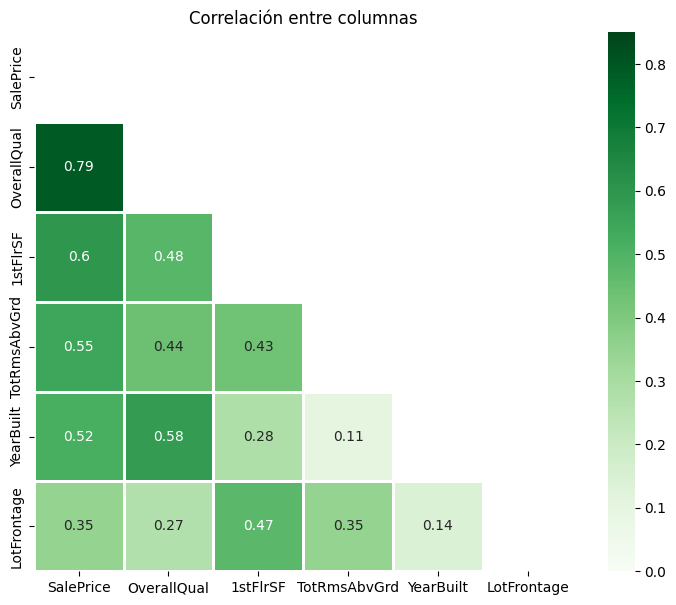

Las dos correlaciones más altas son:
('OverallQual', 'SalePrice')  y  ('1stFlrSF', 'SalePrice')


In [311]:
df.correlacion()

In [312]:
df.regresion_lineal('1stFlrSF', 'SalePrice', 50, 5, 0.0000001)

El error en el epoch 5 es de 6875800992.812125
El error en el epoch 10 es de 3060158611.260475
El error en el epoch 15 es de 2316502152.5137186
El error en el epoch 20 es de 2171565889.918507
El error en el epoch 25 es de 2143318271.8312905
El error en el epoch 30 es de 2137812896.021244
El error en el epoch 35 es de 2136739910.234875
El error en el epoch 40 es de 2136530783.0374062
El error en el epoch 45 es de 2136490019.1061745
El error en el epoch 50 es de 2136482068.635134


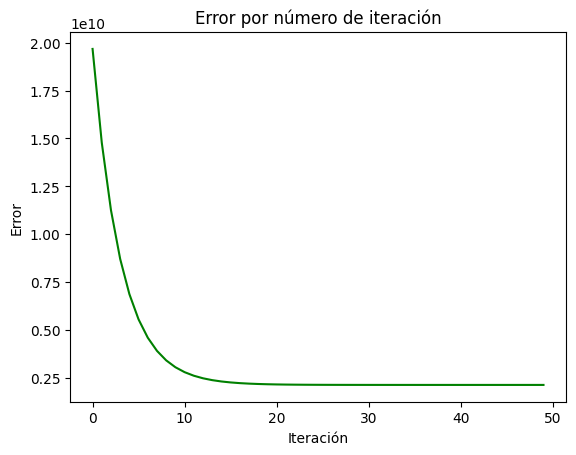

In [313]:
df.graficarError()

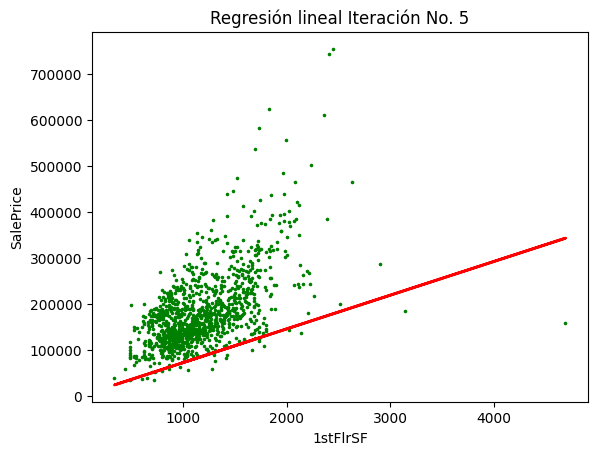

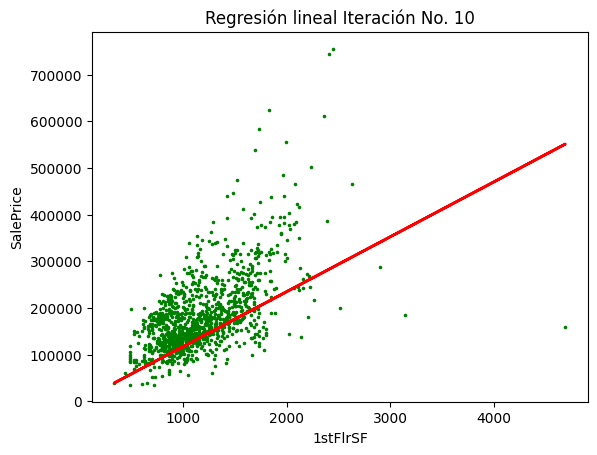

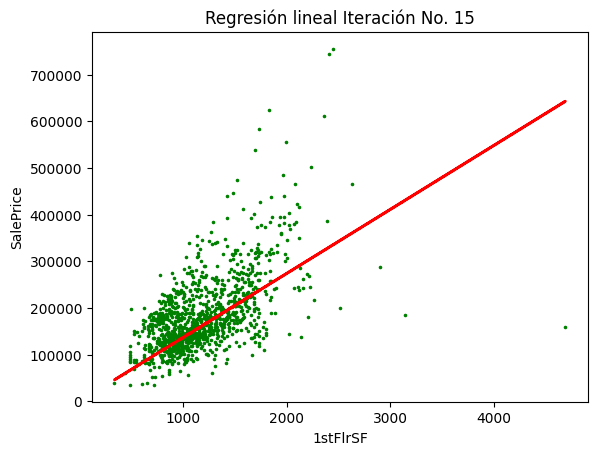

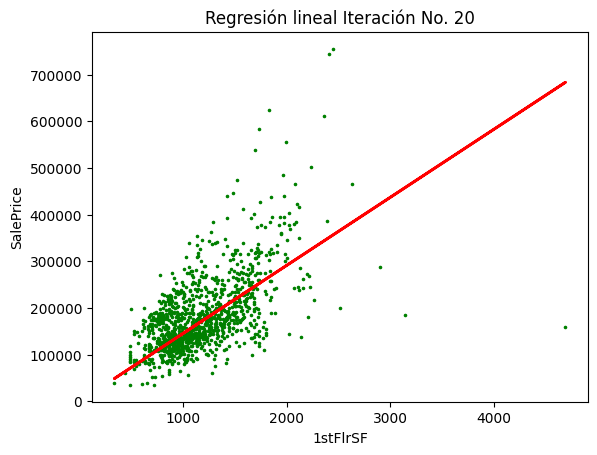

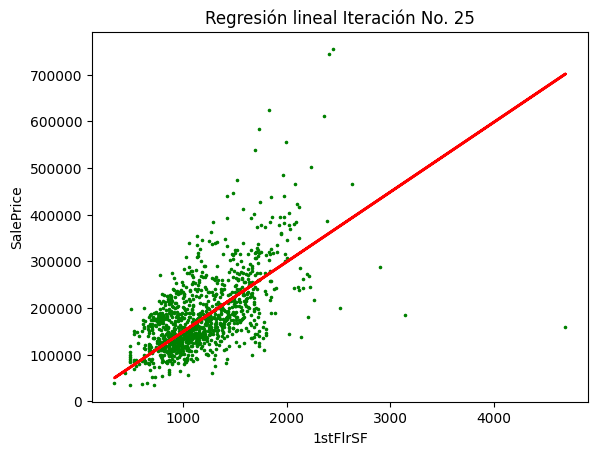

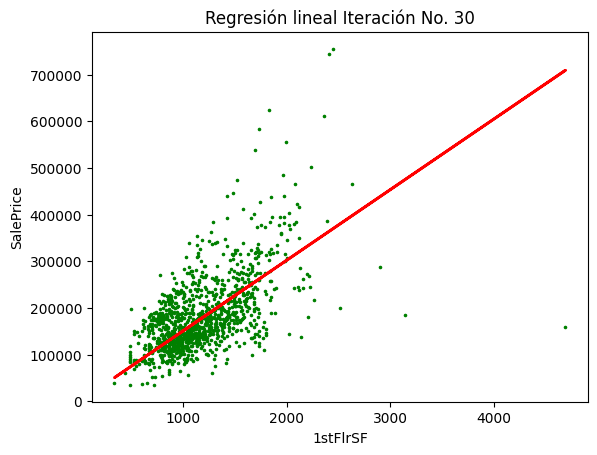

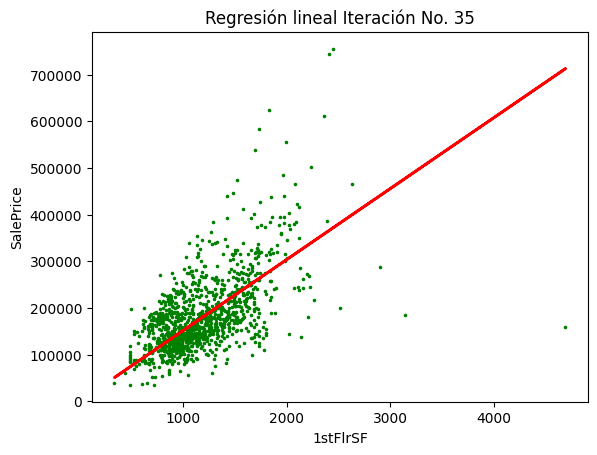

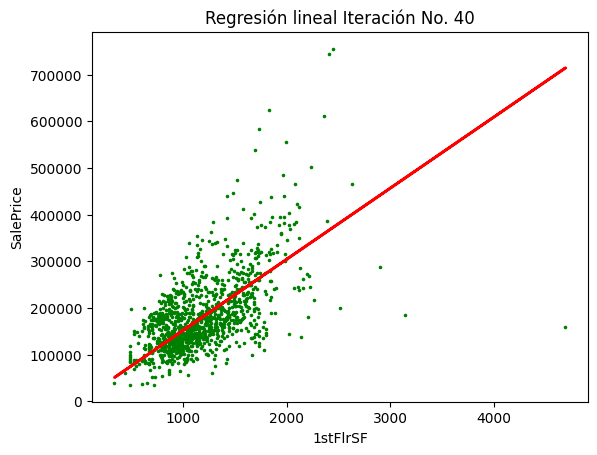

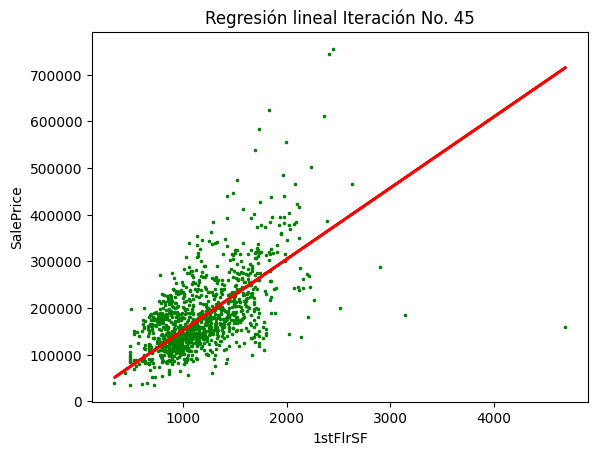

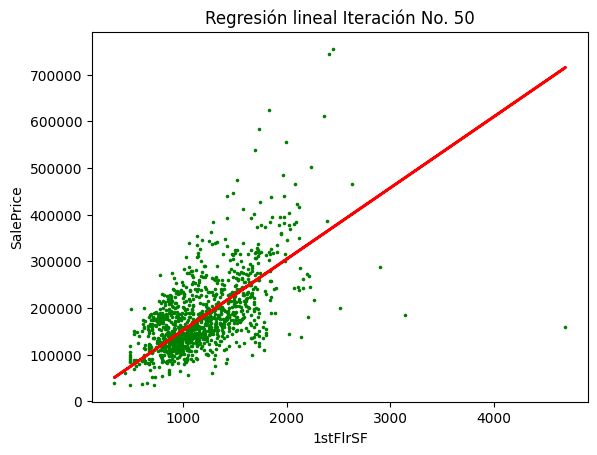

In [314]:
df.graficarModelo('1stFlrSF', 'SalePrice',5)

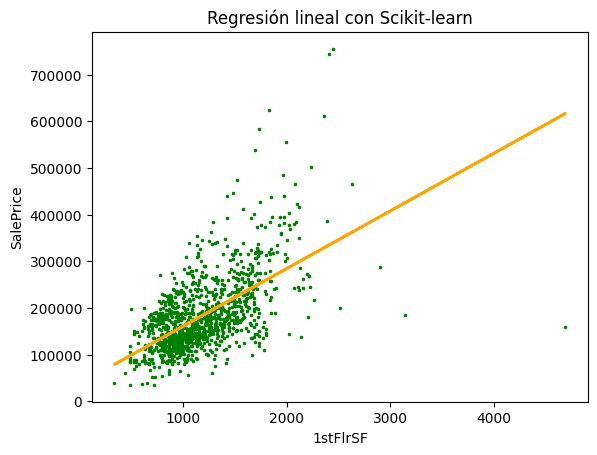

In [315]:
df.regresion_scikit('1stFlrSF', 'SalePrice')

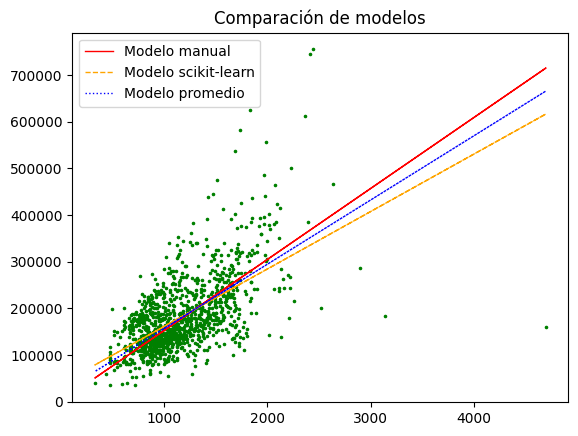

In [316]:
df.comparacion()